# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distributions involved. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline



def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 20
learning_rate  = 0.001
batch_size = 64
### Choose a value for the size of the latent space
latent_dim = 32
image_size = 28

###

# Define here the any extra hyperparameters you used.

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x



## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')

## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Encoder
        self.fc1 = nn.Linear(784, 600)
        self.fc2 = nn.Linear(600, 400)

        # mean
        self.fcmean = nn.Linear(400, latent_dim)

        # variance
        self.fcsig = nn.Linear(400, latent_dim)

        # decorder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fcmean(x)
        logvar = self.fcsig(x)
        return mean, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        sigma = torch.exp(logvar)
        sample = torch.randn((sigma.size(0), sigma.size(1))).to(device)
        z = mu + sigma*sample
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = F.relu(self.fc3(z))
        z = torch.sigmoid(self.fc4(z)) # Sigmoid to have value between 0 and 1
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        xbar = self.decode(z)
        return xbar, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 1064648
VAE(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=400, bias=True)
  (fcmean): Linear(in_features=400, out_features=32, bias=True)
  (fcsig): Linear(in_features=400, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


## Training loop

In [0]:
def plot_image(inputt, outputt):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    grid_img1 = make_grid(inputt, nrow=8)
    grid_img2 = make_grid(outputt, nrow=8)

    ax1.set_title("Input batch")
    ax2.set_title("Output batch")

    ax1.imshow(grid_img1.permute(1,2,0))
    ax2.imshow(grid_img2.permute(1,2,0))
    plt.show()


Epoch: [0/20]	Iteration 0/938	kl_loss = 2.9900	rec_loss = 11790.0977	loss = 11793.0879

Epoch: [0/20]	Iteration 300/938	kl_loss = 348.2522	rec_loss = 2312.3367	loss = 2660.5889

Epoch: [0/20]	Iteration 600/938	kl_loss = 530.5248	rec_loss = 1632.2720	loss = 2162.7969

Epoch: [0/20]	Iteration 900/938	kl_loss = 525.7083	rec_loss = 1438.8239	loss = 1964.5322

--------------------------------------------------
 END EPOCH
Epoch [1/20]	AVG epoch kl_loss = 394.3193	AVG epoch rec_loss = 2165.2590	AVG epoch loss = 2559.5784


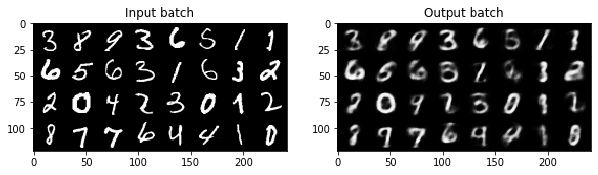

--------------------------------------------------
Epoch: [1/20]	Iteration 0/938	kl_loss = 527.1758	rec_loss = 1302.7849	loss = 1829.9607

Epoch: [1/20]	Iteration 300/938	kl_loss = 517.5383	rec_loss = 1288.4636	loss = 1806.0020

Epoch: [1/20]	Iteration 600/938	kl_loss = 576.3571	rec_loss = 1380.2477	loss = 1956.6047

Epoch: [1/20]	Iteration 900/938	kl_loss = 543.5640	rec_loss = 1166.8046	loss = 1710.3685

--------------------------------------------------
 END EPOCH
Epoch [2/20]	AVG epoch kl_loss = 549.5432	AVG epoch rec_loss = 1225.7770	AVG epoch loss = 1775.3202


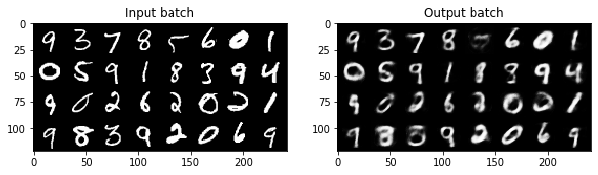

--------------------------------------------------
Epoch: [2/20]	Iteration 0/938	kl_loss = 564.2675	rec_loss = 1137.4849	loss = 1701.7523

Epoch: [2/20]	Iteration 300/938	kl_loss = 554.7938	rec_loss = 1058.4839	loss = 1613.2777

Epoch: [2/20]	Iteration 600/938	kl_loss = 581.2502	rec_loss = 1119.8691	loss = 1701.1194

Epoch: [2/20]	Iteration 900/938	kl_loss = 599.8746	rec_loss = 1053.8713	loss = 1653.7460

--------------------------------------------------
 END EPOCH
Epoch [3/20]	AVG epoch kl_loss = 575.4357	AVG epoch rec_loss = 1057.8385	AVG epoch loss = 1633.2742


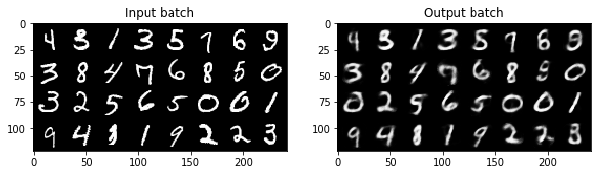

--------------------------------------------------
Epoch: [3/20]	Iteration 0/938	kl_loss = 570.1060	rec_loss = 1004.2942	loss = 1574.4001

Epoch: [3/20]	Iteration 300/938	kl_loss = 565.5500	rec_loss = 1023.9650	loss = 1589.5150

Epoch: [3/20]	Iteration 600/938	kl_loss = 592.3264	rec_loss = 1016.7656	loss = 1609.0920

Epoch: [3/20]	Iteration 900/938	kl_loss = 588.7254	rec_loss = 984.0415	loss = 1572.7668

--------------------------------------------------
 END EPOCH
Epoch [4/20]	AVG epoch kl_loss = 586.4425	AVG epoch rec_loss = 985.1437	AVG epoch loss = 1571.5861


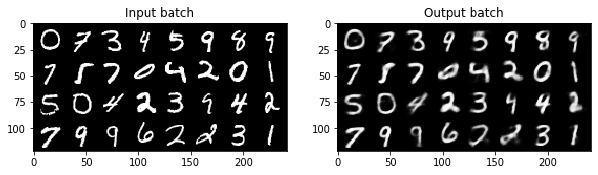

--------------------------------------------------
Epoch: [4/20]	Iteration 0/938	kl_loss = 605.5427	rec_loss = 969.7052	loss = 1575.2479

Epoch: [4/20]	Iteration 300/938	kl_loss = 589.5996	rec_loss = 925.4778	loss = 1515.0774

Epoch: [4/20]	Iteration 600/938	kl_loss = 592.4466	rec_loss = 1052.3141	loss = 1644.7607

Epoch: [4/20]	Iteration 900/938	kl_loss = 590.2026	rec_loss = 934.9445	loss = 1525.1472

--------------------------------------------------
 END EPOCH
Epoch [5/20]	AVG epoch kl_loss = 593.5081	AVG epoch rec_loss = 944.8095	AVG epoch loss = 1538.3176


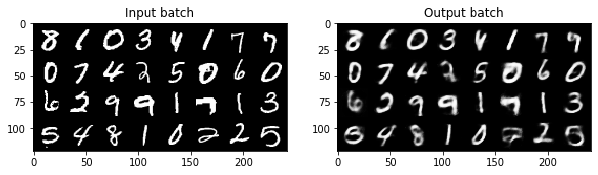

--------------------------------------------------
Epoch: [5/20]	Iteration 0/938	kl_loss = 585.8712	rec_loss = 908.4237	loss = 1494.2949

Epoch: [5/20]	Iteration 300/938	kl_loss = 585.0722	rec_loss = 905.8723	loss = 1490.9445

Epoch: [5/20]	Iteration 600/938	kl_loss = 616.1974	rec_loss = 996.7349	loss = 1612.9323

Epoch: [5/20]	Iteration 900/938	kl_loss = 612.9910	rec_loss = 941.4366	loss = 1554.4276

--------------------------------------------------
 END EPOCH
Epoch [6/20]	AVG epoch kl_loss = 598.6911	AVG epoch rec_loss = 916.0597	AVG epoch loss = 1514.7508


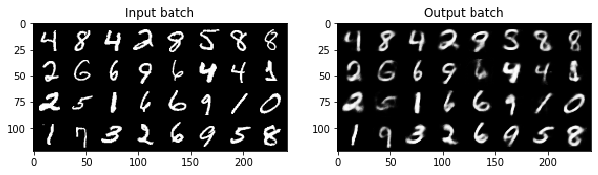

--------------------------------------------------
Epoch: [6/20]	Iteration 0/938	kl_loss = 598.7966	rec_loss = 918.7357	loss = 1517.5322

Epoch: [6/20]	Iteration 300/938	kl_loss = 582.5502	rec_loss = 813.4646	loss = 1396.0148

Epoch: [6/20]	Iteration 600/938	kl_loss = 620.2463	rec_loss = 955.1929	loss = 1575.4392

Epoch: [6/20]	Iteration 900/938	kl_loss = 593.6174	rec_loss = 914.0892	loss = 1507.7067

--------------------------------------------------
 END EPOCH
Epoch [7/20]	AVG epoch kl_loss = 602.7931	AVG epoch rec_loss = 895.7946	AVG epoch loss = 1498.5877


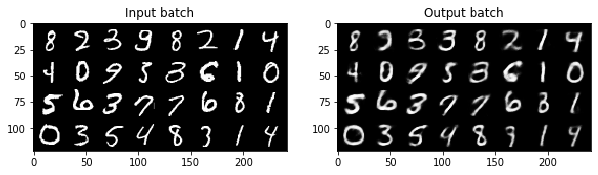

--------------------------------------------------
Epoch: [7/20]	Iteration 0/938	kl_loss = 614.6624	rec_loss = 756.4882	loss = 1371.1506

Epoch: [7/20]	Iteration 300/938	kl_loss = 639.3511	rec_loss = 923.9470	loss = 1563.2981

Epoch: [7/20]	Iteration 600/938	kl_loss = 624.5577	rec_loss = 836.5994	loss = 1461.1571

Epoch: [7/20]	Iteration 900/938	kl_loss = 615.0116	rec_loss = 908.7564	loss = 1523.7681

--------------------------------------------------
 END EPOCH
Epoch [8/20]	AVG epoch kl_loss = 606.2568	AVG epoch rec_loss = 879.4601	AVG epoch loss = 1485.7170


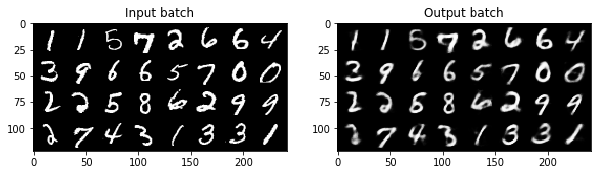

--------------------------------------------------
Epoch: [8/20]	Iteration 0/938	kl_loss = 630.0735	rec_loss = 958.9214	loss = 1588.9949

Epoch: [8/20]	Iteration 300/938	kl_loss = 614.5023	rec_loss = 898.0226	loss = 1512.5249

Epoch: [8/20]	Iteration 600/938	kl_loss = 591.8458	rec_loss = 866.8821	loss = 1458.7278

Epoch: [8/20]	Iteration 900/938	kl_loss = 625.0973	rec_loss = 877.7426	loss = 1502.8398

--------------------------------------------------
 END EPOCH
Epoch [9/20]	AVG epoch kl_loss = 608.5904	AVG epoch rec_loss = 865.9338	AVG epoch loss = 1474.5242


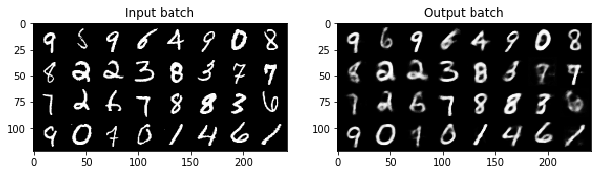

--------------------------------------------------
Epoch: [9/20]	Iteration 0/938	kl_loss = 642.3986	rec_loss = 863.6224	loss = 1506.0210

Epoch: [9/20]	Iteration 300/938	kl_loss = 603.0197	rec_loss = 772.1204	loss = 1375.1401

Epoch: [9/20]	Iteration 600/938	kl_loss = 636.1519	rec_loss = 872.8188	loss = 1508.9707

Epoch: [9/20]	Iteration 900/938	kl_loss = 606.9830	rec_loss = 932.4702	loss = 1539.4532

--------------------------------------------------
 END EPOCH
Epoch [10/20]	AVG epoch kl_loss = 610.6777	AVG epoch rec_loss = 854.2513	AVG epoch loss = 1464.9290


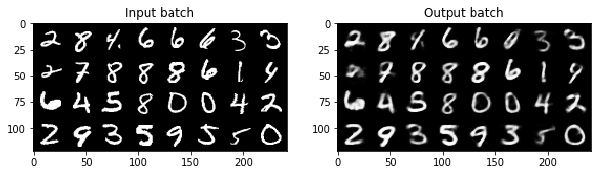

--------------------------------------------------
Epoch: [10/20]	Iteration 0/938	kl_loss = 608.9859	rec_loss = 838.4027	loss = 1447.3887

Epoch: [10/20]	Iteration 300/938	kl_loss = 612.0989	rec_loss = 885.1277	loss = 1497.2266

Epoch: [10/20]	Iteration 600/938	kl_loss = 609.3979	rec_loss = 855.2668	loss = 1464.6648

Epoch: [10/20]	Iteration 900/938	kl_loss = 590.4832	rec_loss = 794.4647	loss = 1384.9479

--------------------------------------------------
 END EPOCH
Epoch [11/20]	AVG epoch kl_loss = 612.6676	AVG epoch rec_loss = 845.1167	AVG epoch loss = 1457.7843


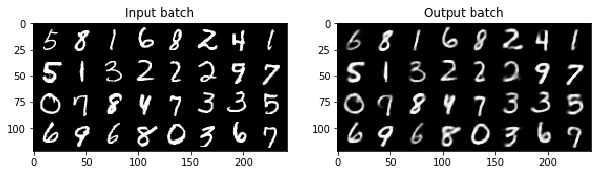

--------------------------------------------------
Epoch: [11/20]	Iteration 0/938	kl_loss = 640.7278	rec_loss = 857.3089	loss = 1498.0366

Epoch: [11/20]	Iteration 300/938	kl_loss = 616.2940	rec_loss = 772.0970	loss = 1388.3910

Epoch: [11/20]	Iteration 600/938	kl_loss = 612.7222	rec_loss = 843.0970	loss = 1455.8192

Epoch: [11/20]	Iteration 900/938	kl_loss = 601.0894	rec_loss = 818.8043	loss = 1419.8938

--------------------------------------------------
 END EPOCH
Epoch [12/20]	AVG epoch kl_loss = 614.2177	AVG epoch rec_loss = 836.1123	AVG epoch loss = 1450.3300


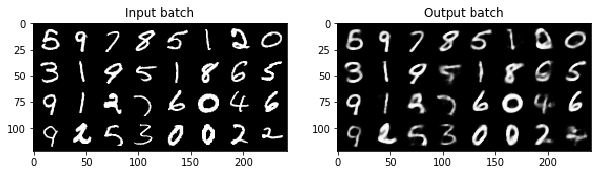

--------------------------------------------------
Epoch: [12/20]	Iteration 0/938	kl_loss = 630.0857	rec_loss = 812.4093	loss = 1442.4950

Epoch: [12/20]	Iteration 300/938	kl_loss = 614.7130	rec_loss = 891.5758	loss = 1506.2888

Epoch: [12/20]	Iteration 600/938	kl_loss = 627.3577	rec_loss = 809.7659	loss = 1437.1235

Epoch: [12/20]	Iteration 900/938	kl_loss = 630.1716	rec_loss = 924.8738	loss = 1555.0454

--------------------------------------------------
 END EPOCH
Epoch [13/20]	AVG epoch kl_loss = 615.2311	AVG epoch rec_loss = 828.6951	AVG epoch loss = 1443.9262


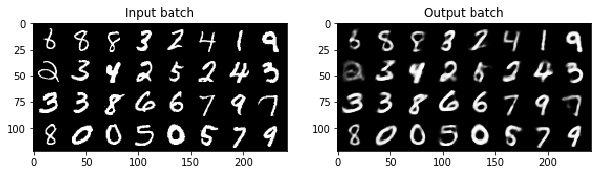

--------------------------------------------------
Epoch: [13/20]	Iteration 0/938	kl_loss = 604.6555	rec_loss = 773.3342	loss = 1377.9897

Epoch: [13/20]	Iteration 300/938	kl_loss = 625.4193	rec_loss = 807.5413	loss = 1432.9606

Epoch: [13/20]	Iteration 600/938	kl_loss = 611.0049	rec_loss = 823.2899	loss = 1434.2947

Epoch: [13/20]	Iteration 900/938	kl_loss = 593.7330	rec_loss = 863.6580	loss = 1457.3910

--------------------------------------------------
 END EPOCH
Epoch [14/20]	AVG epoch kl_loss = 615.9367	AVG epoch rec_loss = 821.9495	AVG epoch loss = 1437.8862


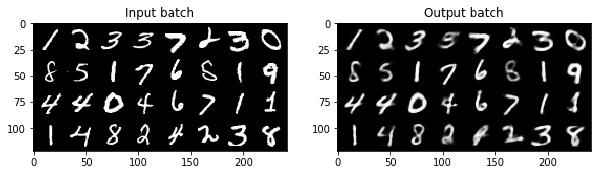

--------------------------------------------------
Epoch: [14/20]	Iteration 0/938	kl_loss = 594.8851	rec_loss = 765.9791	loss = 1360.8643

Epoch: [14/20]	Iteration 300/938	kl_loss = 629.5868	rec_loss = 789.6850	loss = 1419.2717

Epoch: [14/20]	Iteration 600/938	kl_loss = 619.5408	rec_loss = 878.8774	loss = 1498.4182

Epoch: [14/20]	Iteration 900/938	kl_loss = 628.0311	rec_loss = 794.5131	loss = 1422.5442

--------------------------------------------------
 END EPOCH
Epoch [15/20]	AVG epoch kl_loss = 617.4497	AVG epoch rec_loss = 815.1916	AVG epoch loss = 1432.6413


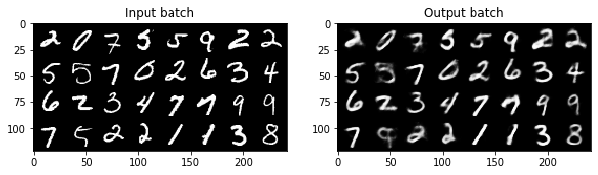

--------------------------------------------------
Epoch: [15/20]	Iteration 0/938	kl_loss = 605.0052	rec_loss = 787.1349	loss = 1392.1401

Epoch: [15/20]	Iteration 300/938	kl_loss = 627.6804	rec_loss = 789.5945	loss = 1417.2749

Epoch: [15/20]	Iteration 600/938	kl_loss = 605.3073	rec_loss = 771.7892	loss = 1377.0966

Epoch: [15/20]	Iteration 900/938	kl_loss = 631.6807	rec_loss = 850.4353	loss = 1482.1160

--------------------------------------------------
 END EPOCH
Epoch [16/20]	AVG epoch kl_loss = 617.8521	AVG epoch rec_loss = 809.5849	AVG epoch loss = 1427.4370


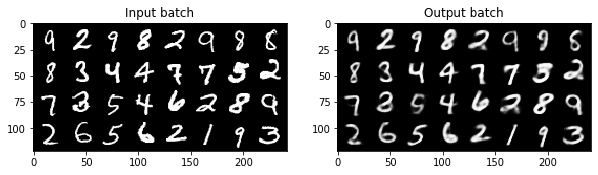

--------------------------------------------------
Epoch: [16/20]	Iteration 0/938	kl_loss = 612.8137	rec_loss = 798.6484	loss = 1411.4622

Epoch: [16/20]	Iteration 300/938	kl_loss = 637.8490	rec_loss = 836.1057	loss = 1473.9547

Epoch: [16/20]	Iteration 600/938	kl_loss = 636.4674	rec_loss = 821.4148	loss = 1457.8822

Epoch: [16/20]	Iteration 900/938	kl_loss = 582.5637	rec_loss = 794.0746	loss = 1376.6382

--------------------------------------------------
 END EPOCH
Epoch [17/20]	AVG epoch kl_loss = 619.0539	AVG epoch rec_loss = 804.4399	AVG epoch loss = 1423.4938


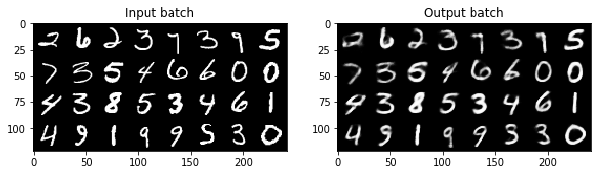

--------------------------------------------------
Epoch: [17/20]	Iteration 0/938	kl_loss = 608.8820	rec_loss = 760.5422	loss = 1369.4242

Epoch: [17/20]	Iteration 300/938	kl_loss = 589.0454	rec_loss = 770.8006	loss = 1359.8459

Epoch: [17/20]	Iteration 600/938	kl_loss = 597.6012	rec_loss = 799.4352	loss = 1397.0364

Epoch: [17/20]	Iteration 900/938	kl_loss = 623.9796	rec_loss = 772.0718	loss = 1396.0513

--------------------------------------------------
 END EPOCH
Epoch [18/20]	AVG epoch kl_loss = 618.1798	AVG epoch rec_loss = 799.3805	AVG epoch loss = 1417.5603


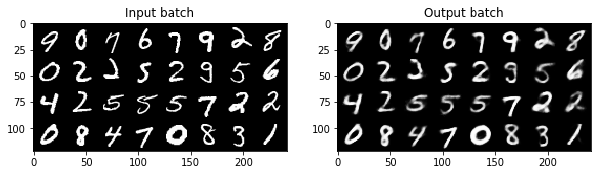

--------------------------------------------------
Epoch: [18/20]	Iteration 0/938	kl_loss = 630.5827	rec_loss = 918.9731	loss = 1549.5559

Epoch: [18/20]	Iteration 300/938	kl_loss = 631.4662	rec_loss = 772.6813	loss = 1404.1475

Epoch: [18/20]	Iteration 600/938	kl_loss = 604.6092	rec_loss = 815.2233	loss = 1419.8325

Epoch: [18/20]	Iteration 900/938	kl_loss = 639.7206	rec_loss = 847.2230	loss = 1486.9436

--------------------------------------------------
 END EPOCH
Epoch [19/20]	AVG epoch kl_loss = 619.8627	AVG epoch rec_loss = 794.0003	AVG epoch loss = 1413.8630


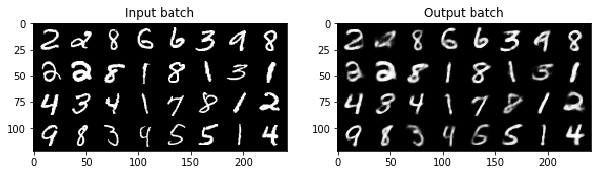

--------------------------------------------------
Epoch: [19/20]	Iteration 0/938	kl_loss = 652.0846	rec_loss = 788.2648	loss = 1440.3494

Epoch: [19/20]	Iteration 300/938	kl_loss = 631.9991	rec_loss = 726.3697	loss = 1358.3688

Epoch: [19/20]	Iteration 600/938	kl_loss = 626.6459	rec_loss = 777.2914	loss = 1403.9373

Epoch: [19/20]	Iteration 900/938	kl_loss = 611.7473	rec_loss = 824.4401	loss = 1436.1874

--------------------------------------------------
 END EPOCH
Epoch [20/20]	AVG epoch kl_loss = 620.9794	AVG epoch rec_loss = 789.9451	AVG epoch loss = 1410.9245


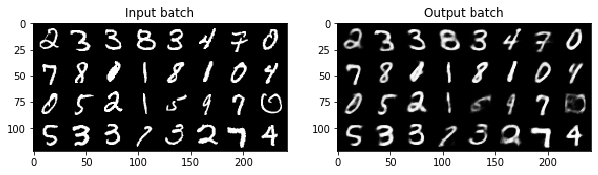

--------------------------------------------------


In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(xbar, x, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # KL loss computed based on https://arxiv.org/pdf/1312.6114.pdf 
        # Appendix B
        kl_loss = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # rec_loss = F.binary_cross_entropy(xbar.view(-1), x.view(-1), reduction='sum')
        rec_loss = F.mse_loss(xbar.view(-1), x.view(-1), reduction='sum')

        return rec_loss + kl_loss, rec_loss, kl_loss
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

print_every = 300
losses = []
kl_losses = []
rec_losses = []
model.train()
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        loss_epoch = 0
        kl_loss_epoch = 0
        rec_loss_epoch = 0
        for batch_idx, data in enumerate(loader_train):
            b_size = data[0].size(0)
            model.zero_grad()

            x = data[0].to(device).view(-1,784)
            xbar, mu, logvar = model(x)
            loss, rec_loss, kl_loss = loss_function_VAE(xbar, x, mu, logvar)
            loss.backward()

            loss_epoch += loss.item()
            rec_loss_epoch += rec_loss.item()
            kl_loss_epoch += kl_loss.item()

            kl_losses.append(kl_loss.item())
            rec_losses.append(rec_loss.item())
            losses.append(loss.item())
            
            optimizer.step()

            if batch_idx % print_every == 0:
                    print(
                        (
                            f'Epoch: [{epoch}/{num_epochs}]\t'
                            f'Iteration {batch_idx}/{len(loader_train)}\t'
                            f'kl_loss = {kl_loss.item():.4f}\t'
                            f'rec_loss = {rec_loss.item():.4f}\t'
                            f'loss = {loss.item():.4f}'))
                    print()
        print('--------------------------------------------------')
        print(" END EPOCH")
        print(
            (
                f'Epoch [{epoch+1}/{num_epochs}]\t'
                f'AVG epoch kl_loss = {kl_loss_epoch/ len(loader_train):.4f}\t'
                f'AVG epoch rec_loss = {rec_loss_epoch/ len(loader_train):.4f}\t'
                f'AVG epoch loss = {loss_epoch/ len(loader_train):.4f}'))
        plot_image(x.cpu().view(-1,1,28,28), xbar.cpu().detach().view(-1,1,28,28))
        print('--------------------------------------------------')


        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

--------------------------------------------------


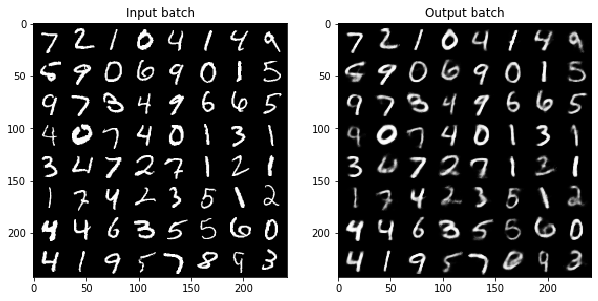

--------------------------------------------------
--------------------------------------------------


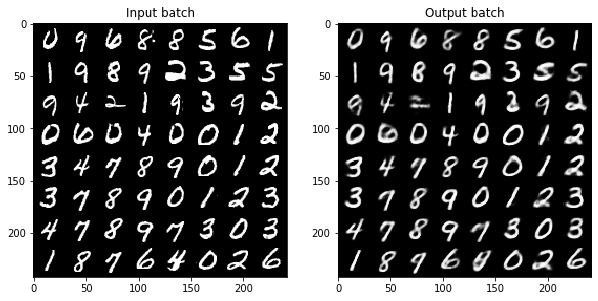

--------------------------------------------------
Test set loss: 1405.8911


In [0]:
model.eval()

test_losses = []
test_kl_losses = []
test_rec_losses = []
test_loss = 0
with torch.no_grad():
    for batch_idx, data in enumerate(loader_test):
        x = data[0].to(device).view(-1,784)
        xbar, mu, logvar = model(x)
        loss, rec_loss, kl_loss = loss_function_VAE(xbar, x, mu, logvar)
        test_kl_losses.append(kl_loss.item())
        test_rec_losses.append(rec_loss.item())
        test_losses.append(loss.item())

        test_loss += loss.item()

        if batch_idx % 100 == 0:
            print('--------------------------------------------------')
            plot_image(x.cpu().view(-1,1,28,28), xbar.cpu().detach().view(-1,1,28,28))
            print('--------------------------------------------------')
            


test_loss /= len(loader_test)
print('Test set loss: {:.4f}'.format(test_loss))

### Your explanations about the loss function here:

The loss function can be written as follow for variationnal auto encoders:

$\mathbf{E}_{z}\left[\log p_{\theta}\left(x^{(i)} | z\right)\right]-D_{K L}\left(q_{\phi}\left(z | x^{(i)}\right) \| p_{\theta}(z)\right)$

The first term being the reconstructed loss (which penalizes the model when the output from the decoder is too different from the input data). This gives how well the model reconstruct an image from the latent space.

I chose the MSE loss to represent this term since the prior can be modeled as Gaussian. However it is possible to use the Binary Cross entropy loss (http://ruishu.io/2018/03/19/bernoulli-vae/). It works especially well on images as the one in MNIST where the distribution of pixels follow a multivariate Bernouilli (either the pixel is white or black).

The second term is the  Kullback–Leibler divergence, this term can be seen as a regularization term. It penalizes the model if the prior $P(z)$ and the encoder $Q(z|x)$ are too different.


The losses computed are the sum of MSE per batch. This has no effect on the training

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


Text(0, 0.5, 'Reconstruction Loss')

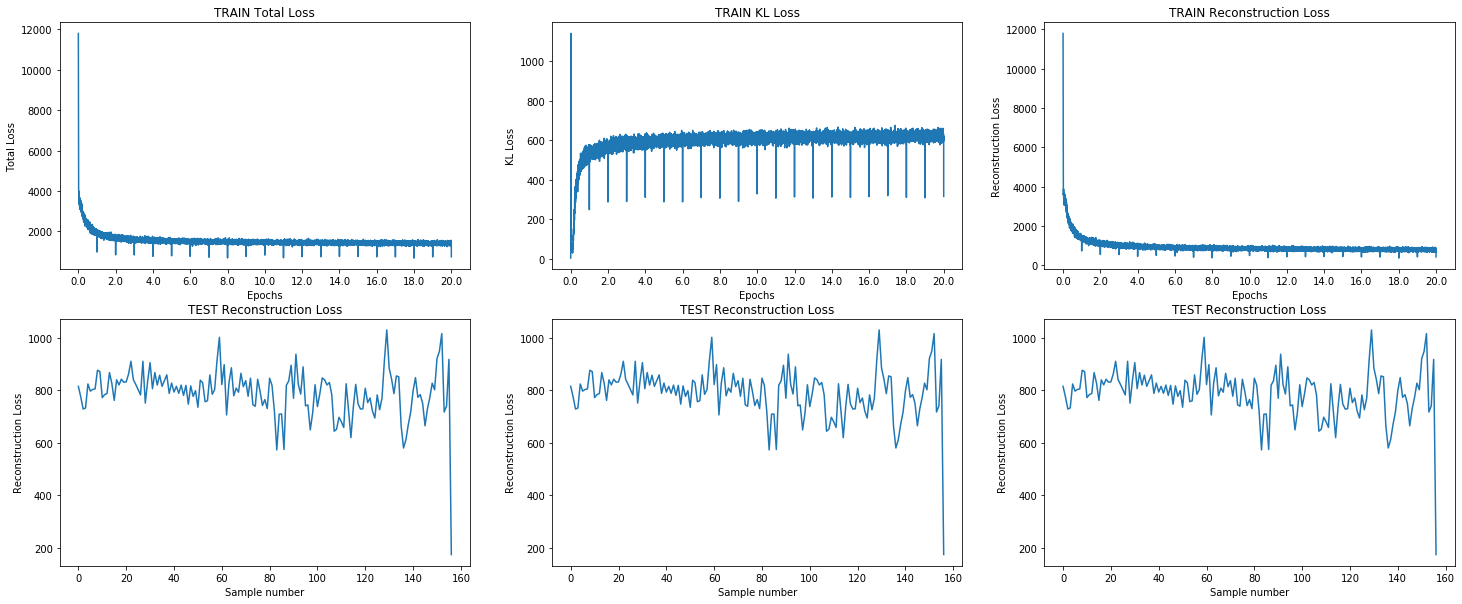

In [0]:
import matplotlib.ticker as ticker

# *CODE FOR PART 1.2a IN THIS CELL*
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 10))

ticks = ticker.FuncFormatter(lambda x, pos: '{}'.format(x*num_epochs/len(losses)))

ax1.plot(losses)
ax1.set_title("TRAIN Total Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Total Loss")
ax1.set_xticks(np.linspace(0,len(losses),num_epochs/2+1))
ax1.xaxis.set_major_formatter(ticks)

ax2.plot(kl_losses)
ax2.set_title("TRAIN KL Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("KL Loss")
ax2.set_xticks(np.linspace(0,len(losses),num_epochs/2+1))
ax2.xaxis.set_major_formatter(ticks)

ax3.plot(rec_losses)
ax3.set_title("TRAIN Reconstruction Loss")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Reconstruction Loss")
ax3.set_xticks(np.linspace(0,len(losses),num_epochs/2+1))
ax3.xaxis.set_major_formatter(ticks)

# TEST

ax4.plot(test_rec_losses)
ax4.set_title("TEST Reconstruction Loss")
ax4.set_xlabel("Sample number")
ax4.set_ylabel("Reconstruction Loss")

ax5.plot(test_rec_losses)
ax5.set_title("TEST Reconstruction Loss")
ax5.set_xlabel("Sample number")
ax5.set_ylabel("Reconstruction Loss")

ax6.plot(test_rec_losses)
ax6.set_title("TEST Reconstruction Loss")
ax6.set_xlabel("Sample number")
ax6.set_ylabel("Reconstruction Loss")


### Your answer to 1.2b here:
The total loss curve, as expected decreases compared to the number of epochs. We ca see that after only 3 epochs, the loss is at its lowest point. After that the training is uneeded.

The KL loss is increasing as the reconstruction loss is decreasing. As said earlier, the KL loss can be seen as a reguliser term. We don't want the VAE to map each class to one subspace of the latent space. Otherwise interpolations in the latent space might yield a bad mnist digit. The KL loss measure how close the distribution of the encoder and the prior are, if the models tries to cluster the digits, then it is penalized.

During my training I did not see posterior collapse since my KL go straight up. However if I had observed it, I would see a generic erpresentation of all the digits since my decoder would basically ignore the latent space.

c/ Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! cp -r CW_VAE/ drive/My\ Drive/Imperial/deepml/cw2

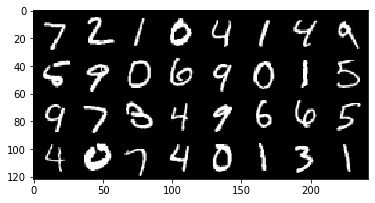

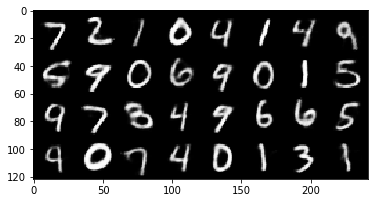

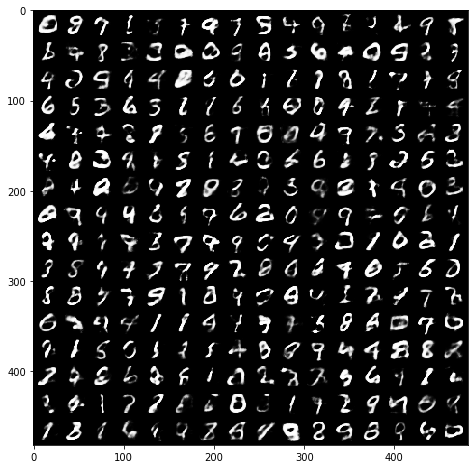

In [0]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch , _, _= model(fixed_input.to(device).view(-1,784))
    recon_batch = recon_batch.view(-1,1,28,28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z).view(n_samples,-1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

In [0]:
from sklearn.manifold import TSNE

In [0]:
# *CODE FOR PART 1.3a IN THIS CELL*
model.eval()
latent_rep = torch.Tensor([]).to(device)
cp_number = torch.LongTensor([])

with torch.no_grad():
    for batch_idx, data in enumerate(loader_test):
        x = data[0].to(device).view(-1,784)
        z = model.encode(x)
        latent_rep= torch.cat((latent_rep,z[0]))
        cp_number = torch.cat((cp_number, data[1]))

cp_latent_rep = latent_rep.cpu()

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(cp_latent_rep.numpy())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.039s...
[t-SNE] Computed neighbors for 10000 samples in 7.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.685987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.923569
[t-SNE] KL divergence after 300 iterations: 2.848504


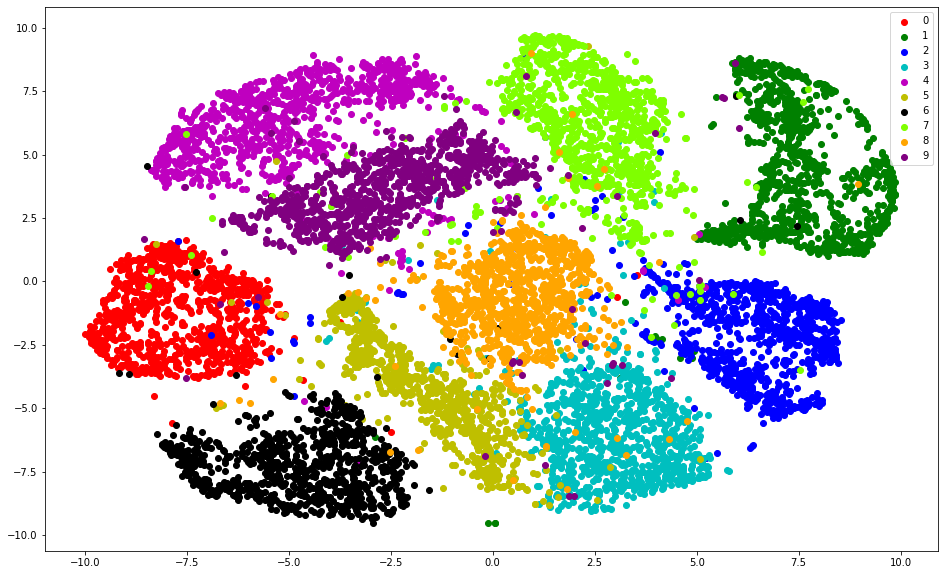

In [0]:
plt.figure(figsize=(16, 10))
target_ids = range(10)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'chartreuse', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(tsne_results[cp_number == i, 0], tsne_results[cp_number == i, 1], c=c, label=label)
plt.legend()
plt.show()


### Your answer to 1.3a here:
From the plot, we can see the different clusters. One for each digit. This is normal, because we are plotting from real value that belong to specific classes. That is why these values lie in a particular subspace of the latent space. We will see with the interpolation whether these clusters are well defined, or if my VAE model is too restrictive (meaning that the sampling did not have the wanted effect).

In [0]:
# *CODE FOR PART 1.3b IN THIS CELL*
class0 = 4
class1 = 3
# Getting the centroids from latent space of the 2 chosen digits
Z_0 = torch.tensor([]).to(device)
Z_1 = torch.tensor([]).to(device)
with torch.no_grad():
    for batch_idx, data in enumerate(loader_test):
        x0 =data[0][data[1] == class0].to(device).view(-1,784)
        x1 =data[0][data[1] == class1].to(device).view(-1,784)

        z0 = model.encode(x0)
        z1 = model.encode(x1)

        Z_0 = torch.cat((Z_0, z0[0]))
        Z_1 = torch.cat((Z_1, z1[0]))

Z_0 = Z_0.cpu()
Z_1 = Z_1.cpu()

Z_0_center = Z_0.mean(dim=0)
Z_1_center = Z_1.mean(dim=0)

In [0]:
# Orientation vector
dir_vect = Z_1_center- Z_0_center

# Path
npoints = 120
interp_vecs = [Z_0_center + k/npoints* dir_vect for k in range(npoints)]

In [0]:
with torch.no_grad():
    representations = torch.stack([model.decode(za.to(device)).view(28,28) for za in interp_vecs])

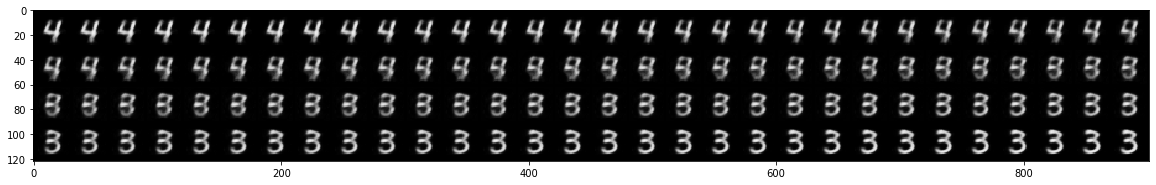

In [0]:
plt.figure(figsize=(20,10))
grid_img1 = make_grid(representations.cpu().view(-1,1,28,28), nrow=30)

plt.imshow(grid_img1.permute(1,2,0))
plt.show()

### Your answer to 1.3b here:
I chose to do an interpolation between 4 and 3. As we can see with the previous plot, the interpolation should go through 9 and 8 before going to 3. The interpolation works quite well, since we are indeed observing first a 4, then a 9 (or 5, there must be a lot of overlap), then a 8 and finally a 3. As expected from VAE, we can guess a digit at each step of the interpolation, even though it might be blurry.

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    plt.figure(figsize=(10,10))
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [0]:
batch_size = 64
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*
# Define here other hyperparameters that you used.

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 40
learning_rate_g = 3e-5
learning_rate_d = 2e-4
latent_vector_size = 300

# Number of channel
nc = 3

# Size of feature maps in generator
n_feature_gen = 256

# Size of feature maps in discriminator
n_feature_disc = 128



In [0]:
def si_tr(h, stride, pad, ksize):
    return (h-1)*stride -2*pad + ksize

def si_dc(h, stride, pad, ksize):
    return (h+2*pad-(ksize-1) -1 )/stride +1

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*
# Inspired from DCGANs paper, but I tried to have an output of 32x32

class Generator(nn.Module):
    def __init__(self, n_feature_gen=n_feature_gen, latent_vector_size=latent_vector_size, residual=True):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.residual = residual
        
        self.l1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, n_feature_gen * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_gen * 8),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*8) x 2 x 2
        )
        if residual:
          self.l1_res = nn.Sequential(
              nn.ConvTranspose2d(latent_vector_size, n_feature_gen * 8, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(n_feature_gen * 8),
          )

        self.l2 = nn.Sequential(
            nn.ConvTranspose2d(n_feature_gen * 8, n_feature_gen * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_gen * 4),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*4) x 4 x 4
        )
        if residual:
          self.l2_res = nn.Sequential(
              nn.ConvTranspose2d(n_feature_gen * 8, n_feature_gen * 4, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(n_feature_gen * 4),
          )

        self.l3 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen * 4, n_feature_gen * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_gen * 2),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*2) x 8 x 8
        )
        if residual:
          self.l3_res = nn.Sequential(
              nn.ConvTranspose2d( n_feature_gen * 4, n_feature_gen * 2, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(n_feature_gen * 2),
          )


        self.l4 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen * 2, n_feature_gen, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_gen),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen) x 16 x 16
        )
        if residual:
          self.l4_res = nn.Sequential(
              nn.ConvTranspose2d( n_feature_gen * 2, n_feature_gen, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(n_feature_gen),
          )

        self.l5 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32 
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        if self.residual:
          x1 = self.l1(z) + self.l1_res(z)
          x2 = self.l2(x1) + self.l2_res(x1)
          x3 = self.l3(x2) + self.l3_res(x2)
          x4 = self.l4(x3) + self.l4_res(x3)
          x5 = self.l5(x4)
        else:
          x1 = self.l1(z)
          x2 = self.l2(x1)
          x3 = self.l3(x2)
          x4 = self.l4(x3)
          x5 = self.l5(x4)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x5

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self, n_feature_disc=n_feature_disc):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.dcr = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, n_feature_disc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (n_feature_disc) x 28 x 28
            nn.Conv2d(n_feature_disc, n_feature_disc * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*2) x 14 x 14
            nn.Conv2d(n_feature_disc * 2, n_feature_disc * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*4) x 8 x 8
            nn.Conv2d(n_feature_disc * 4, n_feature_disc * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*8) x 4 x 4
            nn.Conv2d(n_feature_disc * 8, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.dcr(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 107768832
Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(300, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1_res): Sequential(
    (0): ConvTranspose2d(300, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2_res): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l3): Seque

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
def plot_image(inputt):
    plt.figure(figsize=(15,15))
    grid_img1 = make_grid(inputt, nrow=8)
    plt.title("Generated Image")
    plt.imshow(grid_img1.permute(1,2,0))
    plt.show()


In [0]:
# load the model
save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model'

model_G.load_state_dict(torch.load(save_dir+'/resnetmore/DCGAN_model_G.pth'))
model_D.load_state_dict(torch.load(save_dir+'/resnetmore/DCGAN_model_D.pth'))

<All keys matched successfully>

In [0]:
torch.autograd.set_detect_anomaly(True)
train_losses_G = []
train_losses_D = []

print_every = 25

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        if i%print_every == 0:
            print('[%d/%d][%d/%d]\t\t Loss_D: %.4f\t\t Loss_G: %.4f\t\t D(x): %.4f\t\t D(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(loader_train),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    plot_image(denorm(fake.cpu()).detach().float())
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model/resnetend1'
    torch.save(model_G.state_dict(), save_dir+'/DCGAN_model_G.pth')
    torch.save(model_D.state_dict(), save_dir+'/DCGAN_model_D.pth')
            

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# save losses and models
save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model/resnetend1'
torch.save(model_G.state_dict(), save_dir+'/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), save_dir+'/DCGAN_model_D.pth')

# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*
I followed the DCGAN paper architecture and adapted it so that I could have a 3x32x32 picture generated in the end. As far as the discriminator is concerned I chose the same architecture as the Generator but reversed.

At first I tried with ReLu activation function on both discriminator and generator. I managed to get decent result. I then followed what was done in the DCGAN paper (https://arxiv.org/pdf/1511.06434.pdf).

Using batchnorm clearly improved the stability of training. However I did not see much difference between using ReLu and Leaky ReLu in the discriminator.

I tried with feature space depth that are multiples of 64, 128, 256, 512 and 612. My thinking here was that while the generator was not able to fool the discriminator, I would give more capacity to the generator. Indeed this means that the generator does not generate good enough images, and 

And it actually gave better result when I started doing that. Since I was not getting the same class as an output of the generator, my generator was indeed getting better. I kept increasing the feature space depth of the generator until the discriminator could be fooled after several epochs. However it never happened, I stopped with feature space depth of 612, because the training was taking too long. I got quite nice results.

However the GAN that was actually giving the best results has the same architecture, but with residual connections. The training was more unstable at the begining, however, after 10 epochs it seemed to get better than the architecture without the residual connections.

I trained this GAN as follows :
1.   Training on 40 epochs with same learning rate for Generator and Discriminator
2.   Training on 40 epochs with smaller learning rate for Generator
3.   Training on 40 epochs with even smaller learning rate for Generator

I tried increasing the learning rate of the generator, but this was giving bad results in generation. I also tried increasing the kernel size and adding some padding (to keep the same architecture), and I think with more time I would have probably switched to bigger kernel. The generation seemed as good as the previous model for a lot less parameters. You can check at the end of the notebook the experiments I run, and the results with bigger kernel size. I also linked the model weights

As future work, I would have reduced the number of parameters and the depth of feature space inside each layer. Probaly I would have divided each layer into 2 equivalent part. Thanks to this, I could add non linearity, and maybe have a better results. This also would give more sense to the residual connections


## LINK TO MY MODEL
My model being almost 700 MB, I could not upload it on Cate. You will find it available on this link

GENERATOR LINK : https://drive.google.com/file/d/1-VsZvMJ2RlppDXU7Rt_aqvD_lm_qrAAC/view?usp=sharing

DISCRIMINATOR LINK : https://drive.google.com/file/d/1-VxKGxLW4agBF5vQs5U56MRtDxwtOPHy/view?usp=sharing

You will find bellow (at the end of the notebook) another version of this GAN, but with bigger kernel and less weights.

### Generator samples

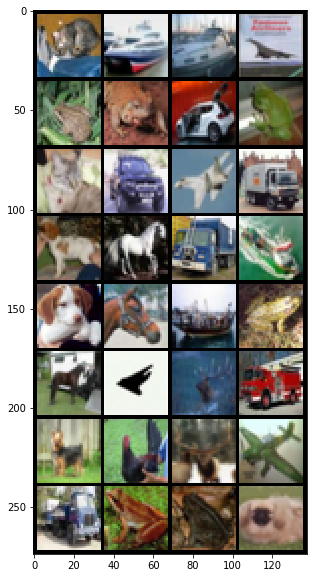

In [0]:
save_dir = '/content/drive/My Drive/deepml/model'
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

In [0]:
# load the model
model_G.load_state_dict(torch.load(save_dir+'/resnetend/DCGAN_model_G.pth'))

<All keys matched successfully>

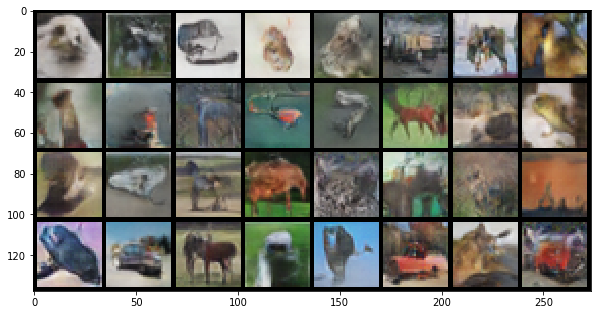

In [0]:
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

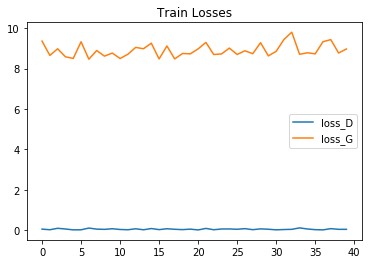

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, len(train_losses_D))), train_losses_D, label='loss_D')
plt.plot(list(range(0, len(train_losses_G))), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

# ANSWER FOR PART 2.2 IN THIS CELL*
This losses curves are actually quite logic. As I explained before, my generator was never able to fool the discriminator. That is why genrator's loss is above discriminator's loss and discriminator's loss seems quite consistent. It was always able to discrimnate fake pictures from real ones.



### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

# ANSWER FOR PART 2.3 IN THIS CELL*
The quality of the pictures is not very good, so it is not possible to tell whether every class is represented. However I can distinguish at least 5 classes (horse, airplanes and cars, trucks and boats). With the pictures from the training, we can guess that frogs are also generated by the generator.
The generator does not seem to generate always the same class in order to fool the discriminator. So I assume that there are no mode collapse. However, I would need to have a better images in order to conclude whether some classes are really missing or not.

If I had collapse mode, I would try increasing the latent space size, so that each class can have its specific subsapce. I would also try to increase the the number of parameter for my generator, because this could be also due to a lack of learning power.

# OTHER MODEL

### Hyper-parameter selection

LINK to models for this architecture : 
* Discriminator : https://drive.google.com/open?id=1-3ilpK6PlK2OCG3vZa6FS2hoDOkb6Sky
* Generator : https://drive.google.com/open?id=1-0H4oGinhv0MAVOlGafSKr8TGz7_NHMN


In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*
# Define here other hyperparameters that you used.

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 40
learning_rate_g = 5e-5
learning_rate_d = 2e-4
latent_vector_size = 150

# Number of channel
nc = 3

# Size of feature maps in generator
n_feature_gen = 128

# Size of feature maps in discriminator
n_feature_disc = 64



In [0]:
def si_tr(h, stride, pad, ksize):
    return (h-1)*stride -2*pad + ksize

def si_dc(h, stride, pad, ksize):
    return (h+2*pad-(ksize-1) -1 )/stride +1

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*
# Inspired from DCGANs paper, but I tried to have an output of 32x32

class Generator(nn.Module):
    def __init__(self, n_feature_gen=n_feature_gen, latent_vector_size=latent_vector_size, residual=True):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.residual = residual
        
        self.l1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, n_feature_gen * 8, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(n_feature_gen * 8),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*8) x 2 x 2
        )
        if residual:
          self.l1_res = nn.Sequential(
              nn.ConvTranspose2d(latent_vector_size, n_feature_gen * 8, kernel_size=6, stride=2, padding=2, bias=False),
              nn.BatchNorm2d(n_feature_gen * 8),
          )

        self.l2 = nn.Sequential(
            nn.ConvTranspose2d(n_feature_gen * 8, n_feature_gen * 4, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(n_feature_gen * 4),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*4) x 4 x 4
        )
        if residual:
          self.l2_res = nn.Sequential(
              nn.ConvTranspose2d(n_feature_gen * 8, n_feature_gen * 4, kernel_size=6, stride=2, padding=2, bias=False),
              nn.BatchNorm2d(n_feature_gen * 4),
          )

        self.l3 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen * 4, n_feature_gen * 2, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(n_feature_gen * 2),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen*2) x 8 x 8
        )
        if residual:
          self.l3_res = nn.Sequential(
              nn.ConvTranspose2d( n_feature_gen * 4, n_feature_gen * 2, kernel_size=6, stride=2, padding=2, bias=False),
              nn.BatchNorm2d(n_feature_gen * 2),
          )


        self.l4 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen * 2, n_feature_gen, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(n_feature_gen),
            nn.ReLU(inplace=True),
            # state size. (n_feature_gen) x 16 x 16
        )
        if residual:
          self.l4_res = nn.Sequential(
              nn.ConvTranspose2d( n_feature_gen * 2, n_feature_gen, kernel_size=6, stride=2, padding=2, bias=False),
              nn.BatchNorm2d(n_feature_gen),
          )

        self.l5 = nn.Sequential(
            nn.ConvTranspose2d( n_feature_gen, nc, kernel_size=6, stride=2, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32 
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        if self.residual:
          x1 = self.l1(z) + self.l1_res(z)
          x2 = self.l2(x1) + self.l2_res(x1)
          x3 = self.l3(x2) + self.l3_res(x2)
          x4 = self.l4(x3) + self.l4_res(x3)
          x5 = self.l5(x4)
        else:
          x1 = self.l1(z)
          x2 = self.l2(x1)
          x3 = self.l3(x2)
          x4 = self.l4(x3)
          x5 = self.l5(x4)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x5

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self, n_feature_disc=n_feature_disc):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.dcr = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, n_feature_disc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (n_feature_disc) x 28 x 28
            nn.Conv2d(n_feature_disc, n_feature_disc * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*2) x 14 x 14
            nn.Conv2d(n_feature_disc * 2, n_feature_disc * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*4) x 8 x 8
            nn.Conv2d(n_feature_disc * 4, n_feature_disc * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_feature_disc * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (n_feature_disc*8) x 4 x 4
            nn.Conv2d(n_feature_disc * 8, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.dcr(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 60625920
Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1_res): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2_res): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l3): Sequential

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
def plot_image(inputt):
    plt.figure(figsize=(15,15))
    grid_img1 = make_grid(inputt, nrow=8)
    plt.title("Generated Image")
    plt.imshow(grid_img1.permute(1,2,0))
    plt.show()


In [0]:
# load the model
save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model'

model_G.load_state_dict(torch.load(save_dir+'/reslilend/DCGAN_model_G.pth'))
model_D.load_state_dict(torch.load(save_dir+'/reslilend/DCGAN_model_D.pth'))

<All keys matched successfully>

In [14]:
torch.autograd.set_detect_anomaly(True)
train_losses_G = []
train_losses_D = []

print_every = 25

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        if i%print_every == 0:
            print('[%d/%d][%d/%d]\t\t Loss_D: %.4f\t\t Loss_G: %.4f\t\t D(x): %.4f\t\t D(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(loader_train),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    plot_image(denorm(fake.cpu()).detach().float())
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model/reslil'
    torch.save(model_G.state_dict(), save_dir+'/DCGAN_model_G.pth')
    torch.save(model_D.state_dict(), save_dir+'/DCGAN_model_D.pth')
            

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# save losses and models
save_dir = '/content/drive/My Drive/Imperial/deepml/cw2/model/reslilend'
torch.save(model_G.state_dict(), save_dir+'/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), save_dir+'/DCGAN_model_D.pth')